In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

from torchvision import transforms
from torchvision import datasets

# Load data properly

Also define a function retrieving all dataloaders (training, validation and test).

In [2]:
def get_dataloader(batch_size):
    transformer = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = datasets.ImageFolder("../train/", transformer)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

    val_dataset = datasets.ImageFolder("../val/", transformer)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

    test_dataset = datasets.ImageFolder("../test/", transformer)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    
    return train_loader, val_loader, test_loader

## Define useful functions to plot and save training curve

In [3]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    # plt.savefig(path.replace(".", ",") + "_train_val_err")
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    # plt.savefig(path.replace(".", ",") + "_train_val_loss")
    plt.show()


def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values
    Args:
        name: name of the model
        batch_size: size of the batch used during training
        learning_rate: learning rate value used during training
        epoch: epoch value
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format( name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
    return path

# Define model

Define model class as well as train and evaluate functions, very useful to train easily our model by just tweaking the hyperparameters.

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'cuda'

In [63]:
def train(net, batch_size=1, learning_rate=0.01, num_epochs=10):
    train_loader, val_loader, _ = get_dataloader(batch_size=batch_size)

    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy.
    # Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of train(train_loader, val_loader, ing data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (torch.argmax(outputs,1) != labels)
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
            "Validation err: {}, Validation loss: {}").format(
                epoch + 1,
                train_err[epoch],
                train_loss[epoch],
                val_err[epoch],
                val_loss[epoch]))
    # Save the trained model to a file
    model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
    torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

    Args:
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        err: A scalar for the avg classification error over the validation set
        loss: A scalar for the average loss function over the validation set
    """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        corr = (torch.argmax(outputs,1) != labels)
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [125]:
class MusicNet(nn.Module):
    def __init__(self):
        super(MusicNet, self).__init__()
        self.name = "musicnet"
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=25, kernel_size=3, stride=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(25*8*10, 128)
        self.fc2 = nn.Linear(128, 10)  # Output layer with 10 classes

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        # print(x.shape)
        x = x.view(-1, 25*8*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [126]:
# Training test to debug
train_loader, _, _ = get_dataloader(batch_size=4)

test = MusicNet()
test = test.to(device)
loss = nn.CrossEntropyLoss()
for i, data in enumerate(train_loader, 0):
    input, label = data[0].to(device), data[1].to(device)
    out = test(input)
    print(out.shape, label.shape)
    # print(torch.argmax(out,1), out[0], label)
    loss(out, label)
    corr = (torch.argmax(out,1) != label)
    break

torch.Size([4, 10]) torch.Size([4])


# Train CNN model

Epoch 1: Train err: 0.8343634116192831, Train loss: 2.18597282965978 |Validation err: 0.68, Validation loss: 2.0891223595692563
Epoch 2: Train err: 0.7268232385661311, Train loss: 1.9459375984528486 |Validation err: 0.68, Validation loss: 1.929687133202186
Epoch 3: Train err: 0.6749072929542645, Train loss: 1.836586897279702 |Validation err: 0.65, Validation loss: 1.7695616391988902
Epoch 4: Train err: 0.6637824474660075, Train loss: 1.782864368429371 |Validation err: 0.63, Validation loss: 1.727540447161748
Epoch 5: Train err: 0.6106304079110012, Train loss: 1.684950903934591 |Validation err: 0.66, Validation loss: 1.7579018473625183
Epoch 6: Train err: 0.5908529048207664, Train loss: 1.5864540648226644 |Validation err: 0.61, Validation loss: 1.7195127743941088
Epoch 7: Train err: 0.5611866501854141, Train loss: 1.5192353795556461 |Validation err: 0.62, Validation loss: 1.5600429223133967
Epoch 8: Train err: 0.5339925834363412, Train loss: 1.4412604099979587 |Validation err: 0.58, Val

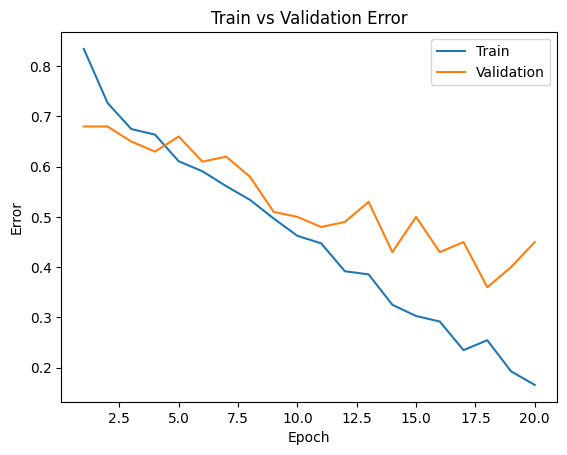

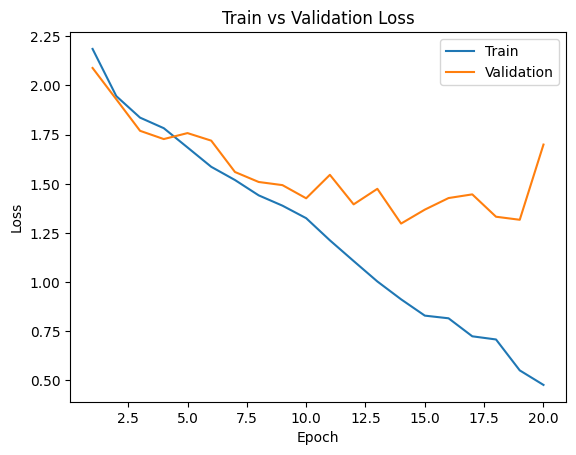

In [128]:
music_net = MusicNet()
music_net = music_net.to(device)

batch_size=8
learning_rate=0.001
num_epochs=20

train(music_net, batch_size, learning_rate, num_epochs)

model_path = get_model_name("musicnet", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train err: 0.8009888751545118, Train loss: 2.1506404152103498 |Validation err: 0.72, Validation loss: 1.9738868474960327
Epoch 2: Train err: 0.7095179233621756, Train loss: 1.8557498408298867 |Validation err: 0.66, Validation loss: 1.7418819299111
Epoch 3: Train err: 0.6699629171817059, Train loss: 1.7850195636936264 |Validation err: 0.64, Validation loss: 1.7253979169405425
Epoch 4: Train err: 0.6625463535228677, Train loss: 1.7434972565548092 |Validation err: 0.72, Validation loss: 1.732337502332834
Epoch 5: Train err: 0.6291718170580964, Train loss: 1.6578429025762222 |Validation err: 0.64, Validation loss: 1.6943427232595591
Epoch 6: Train err: 0.6180469715698393, Train loss: 1.6301798265354306 |Validation err: 0.63, Validation loss: 1.6467415186075063
Epoch 7: Train err: 0.5920889987639061, Train loss: 1.5595769180971033 |Validation err: 0.64, Validation loss: 1.6418076570217426
Epoch 8: Train err: 0.5562422744128553, Train loss: 1.5065141057266909 |Validation err: 0.54, 

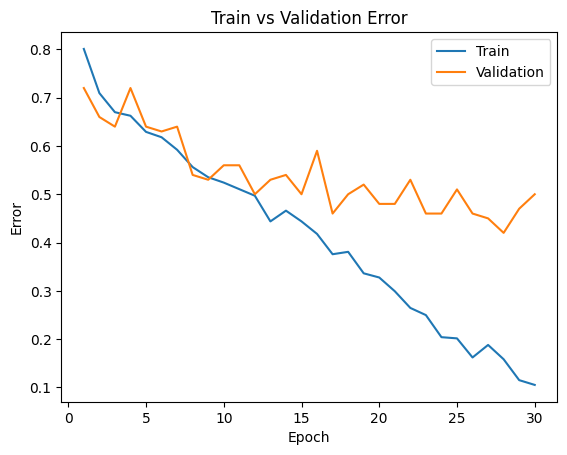

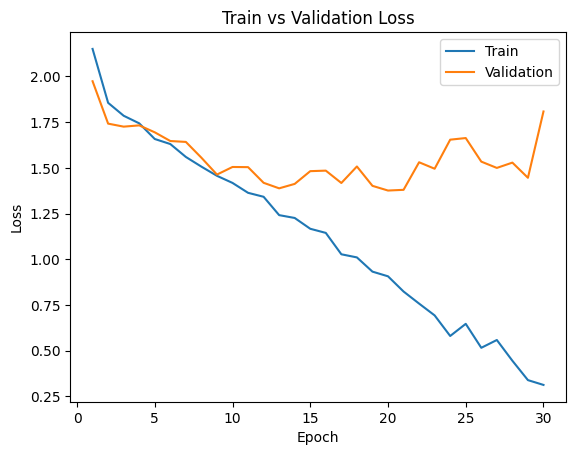

In [134]:
music_net = MusicNet()
music_net = music_net.to(device)

batch_size=8
learning_rate=0.0008
num_epochs=30

train(music_net, batch_size, learning_rate, num_epochs)

model_path = get_model_name("musicnet", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train err: 0.8220024721878862, Train loss: 2.2193856811990926 |Validation err: 0.68, Validation loss: 1.9810064205756555
Epoch 2: Train err: 0.7144622991347342, Train loss: 1.895055631796519 |Validation err: 0.67, Validation loss: 1.7654281854629517
Epoch 3: Train err: 0.6711990111248455, Train loss: 1.7699912716360653 |Validation err: 0.67, Validation loss: 1.6606252376849835
Epoch 4: Train err: 0.657601977750309, Train loss: 1.7446923244233226 |Validation err: 0.63, Validation loss: 1.659459535892193
Epoch 5: Train err: 0.6279357231149567, Train loss: 1.6639627224090052 |Validation err: 0.59, Validation loss: 1.6153147587409387
Epoch 6: Train err: 0.6168108776266996, Train loss: 1.5998413619749687 |Validation err: 0.65, Validation loss: 1.764390468597412
Epoch 7: Train err: 0.6056860321384425, Train loss: 1.617945439675275 |Validation err: 0.63, Validation loss: 1.5569324310009296
Epoch 8: Train err: 0.5723114956736712, Train loss: 1.582616250888974 |Validation err: 0.52, Va

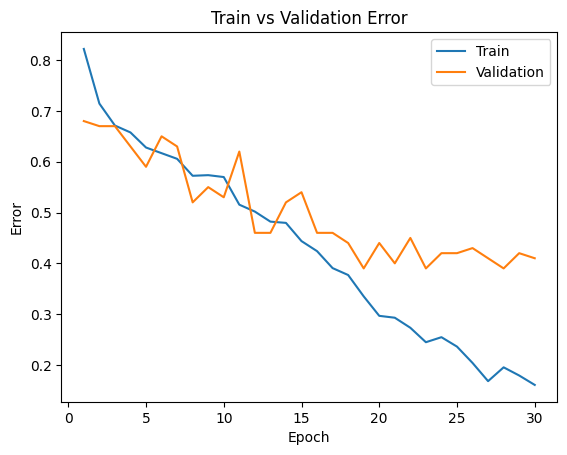

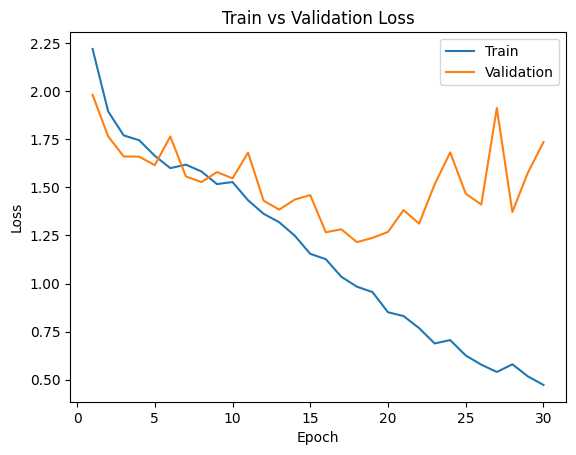

In [135]:
music_net = MusicNet()
music_net = music_net.to(device)

batch_size=8
learning_rate=0.001
num_epochs=30

train(music_net, batch_size, learning_rate, num_epochs)

model_path = get_model_name("musicnet", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

## Retrieve best model and measure its accuracy on test loader

In [138]:
# Load best model
batch_size=8
learning_rate=0.001
num_epochs=30

best_model_path = get_model_name("musicnet", batch_size, learning_rate, num_epochs-1)
best_model = MusicNet()
best_model = best_model.to(device)

best_model.load_state_dict(torch.load(best_model_path))

_, _, test_loader = get_dataloader(batch_size=batch_size)
criterion = nn.CrossEntropyLoss()
err, loss = evaluate(best_model, test_loader, criterion=criterion)

print("Test error: {0}, Test loss: {1}".format(err, loss))

Test error: 0.36, Test loss: 1.2871971772267268
